# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/16ArrZgN5iNL6kLiC2AVBXpQk7SAAxttr?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-3-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
#Maxima
print("The maximum value of 'age' is", np.max(subdf["age"]))
print("The maximum value of 'yredu' is", np.max(subdf["yredu"]))
print("The maximum value of 'capgain' is", np.max(subdf["capgain"]))
print("The maximum value of 'caploss' is", np.max(subdf["caploss"]))
print("The maximum value of 'workhr' is", np.max(subdf["workhr"]))

#Minima
print("The minimum value of 'age' is", np.min(subdf["age"]))
print("The minimum value of 'yredu' is", np.min(subdf["yredu"]))
print("The minimum value of 'capgain' is", np.min(subdf["capgain"]))
print("The minimum value of 'caploss' is", np.min(subdf["caploss"]))
print("The minimum value of 'workhr' is", np.min(subdf["workhr"]))

#Average
print("The average value of 'age' is", np.average(subdf["age"]))
print("The average value of 'yredu' is", np.average(subdf["yredu"]))
print("The average value of 'capgain' is", np.average(subdf["capgain"]))
print("The average value of 'caploss' is", np.average(subdf["caploss"]))
print("The average value of 'workhr' is", np.average(subdf["workhr"]))

#Normalization
df["age"] = subdf["age"]/np.linalg.norm(subdf["age"])
df["yredu"] = subdf["yredu"]/np.linalg.norm(subdf["yredu"])
df["capgain"] = subdf["capgain"]/np.linalg.norm(subdf["capgain"])
df["caploss"] = subdf["caploss"]/np.linalg.norm(subdf["caploss"])
df["workhr"] = subdf["workhr"]/np.linalg.norm(subdf["workhr"])

The maximum value of 'age' is 90
The maximum value of 'yredu' is 16
The maximum value of 'capgain' is 99999
The maximum value of 'caploss' is 4356
The maximum value of 'workhr' is 99
The minimum value of 'age' is 17
The minimum value of 'yredu' is 1
The minimum value of 'capgain' is 0
The minimum value of 'caploss' is 0
The minimum value of 'workhr' is 1
The average value of 'age' is 38.58164675532078
The average value of 'yredu' is 10.0806793403151
The average value of 'capgain' is 1077.6488437087312
The average value of 'caploss' is 87.303829734959
The average value of 'workhr' is 40.437455852092995


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [ ]:
percent_female = (sum(df["sex"] == " Female")/df.shape[0])*100
print("There are ", percent_female, "% female people in our data set.")

There are  33.07945087681583 % female people in our data set.


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
print(df_with_missing.shape[0], " records contained missing features")
print((df_with_missing.shape[0]/df.shape[0])*100, "% of records were removed")

1843  records contained missing features
5.660145572924664 % of records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.005282,0.006925,0.001614,0.0,0.005243,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.006771,0.006925,0.000000,0.0,0.001704,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.005146,0.004794,0.000000,0.0,0.005243,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print("There are ", data.shape[1], " columns in the dataframe 'data'.")

#Where this comes from
data.shape #outputs a tuple in the form of (total rows, total columns)
data.shape[1] #accesses the second element of the tuple, aka. total columns

There are  57  columns in the dataframe 'data'.


57

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.

    return cat_values[feature][np.argmax(onehot)]

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo

from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(datanp, test_size=0.3)
val_data, test_data = train_test_split(temp_data, test_size=0.5)

print("The training set has ", train_data.shape[0], " items")
print("The validation set has ", val_data.shape[0], " items")
print("The testing set has ", test_data.shape[0], " items")

The training set has  21502  items
The validation set has  4608  items
The testing set has  4608  items


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 30),
            nn.ReLU(),
            nn.Linear(30, 15),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(15, 30),
            nn.ReLU(),
            nn.Linear(30, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [ ]:
'''The sigmoid activation in the last step of the decoder ensures that the output has been normalized to the range (0, 1) to match the normalized input,
which aids in reconstruction consistency with the input, and it also provides a smooth gradient that gradually changes across its domain,
making it useful for learning as it avoids abrupt changes in output or small changes in input value.'''

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

import time
import matplotlib.pyplot as plt

def get_val_loss(model, val_loader, criterion):
    '''Helper function to get validation loss for training'''
    total_val_loss = 0.0
    i = 0
    for data in val_loader:
      datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
      recon = model(datam)
      loss = criterion(recon, data)
      total_val_loss += loss.item()
      i += 1
    val_loss = float(total_val_loss)/(i+1)
    return val_loss

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_accuracy = np.zeros(num_epochs) #added to plot accuracy
    train_loss = np.zeros(num_epochs)
    val_accuracy = np.zeros(num_epochs) #added to plot accuracy
    val_loss = np.zeros(num_epochs)

    start_time = time.time()

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        i = 0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
            i += 1
        train_accuracy[epoch] = get_accuracy(model, train_loader) #added to plot accuracy
        train_loss[epoch] = float(total_train_loss)/(i+1)
        val_accuracy[epoch] = get_accuracy(model, valid_loader) #added to plot accuracy
        val_loss[epoch] = get_val_loss(model, valid_loader, criterion)
        print(("Epoch {}: Training accuracy: {}, Training loss: {} |" +
               "Validation accuracy: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_accuracy[epoch],
                   train_loss[epoch],
                   val_accuracy[epoch],
                   val_loss[epoch]))
        #Save current model to file as checkpoint
        model_path = "model_{0}_lr{1}_epoch{2}".format(model.name, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print("Training complete.")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    #Plotting loss
    plt.title("Training Loss vs. Validation Loss")
    plt.plot(range(1, num_epochs+1), train_loss, label="Training")
    plt.plot(range(1, num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.show()

    #Plotting accuracy
    plt.title("Training vs. Validation Accuracy")
    plt.plot(range(1 ,num_epochs+1), train_accuracy, label="Training")
    plt.plot(range(1 ,num_epochs+1), val_accuracy, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_accuracy[-1]))
    print("Final Validation Accuracy: {}".format(val_accuracy[-1]))

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1: Training accuracy: 0.4039469196663876, Training loss: 0.22487970713514957 |Validation accuracy: 0.4000289351851852, Validation loss: 0.16121934333892718
Epoch 2: Training accuracy: 0.4598409450283695, Training loss: 0.09561559002990185 |Validation accuracy: 0.45677806712962965, Validation loss: 0.07122876862548802
Epoch 3: Training accuracy: 0.4605463057700059, Training loss: 0.0700397849171381 |Validation accuracy: 0.4549696180555556, Validation loss: 0.06872564227613684
Epoch 4: Training accuracy: 0.45936036957802373, Training loss: 0.06889718103302693 |Validation accuracy: 0.45619936342592593, Validation loss: 0.06808709047020298
Epoch 5: Training accuracy: 0.4588487892599138, Training loss: 0.0683134284854289 |Validation accuracy: 0.45533130787037035, Validation loss: 0.06756289395159237
Epoch 6: Training accuracy: 0.4601975010076582, Training loss: 0.06771272786779645 |Validation accuracy: 0.4572482638888889, Validation loss: 0.0668292344637113
Epoch 7: Training accuracy:

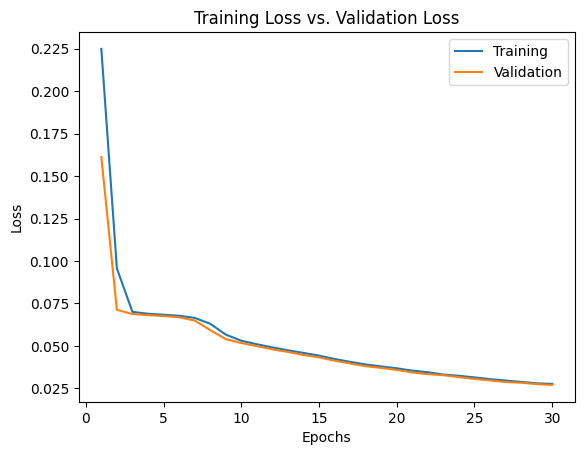

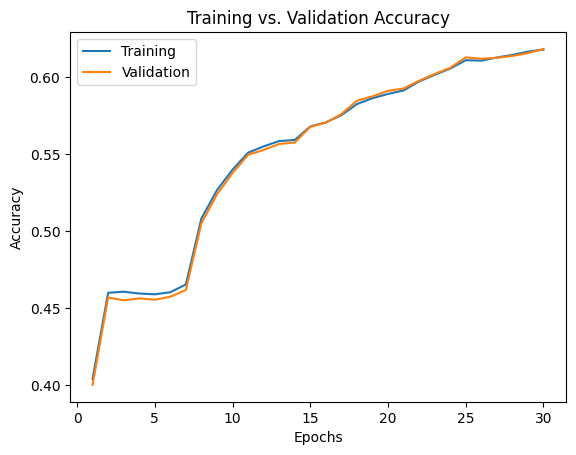

Final Training Accuracy: 0.6177409853346976
Final Validation Accuracy: 0.6181640625


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
model = AutoEncoder()
train(model, train_loader, valid_loader, num_epochs=30)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
model1 = AutoEncoder()
train(model1, train_loader, valid_loader, num_epochs=100) #Increased num_epochs since model still seemed to be improving at end of 30 epochs

'''Post-training notes:
- Final training accuracy: 0.604827457910892
- Final validation accuracy: 0.6058666087962963
- Total time elapsed: 384.72 seconds
While the specific accuracies are less than the above outputted ones, in general the graph displays relative stabilization in the accuracy and a slight upwards trend from the accuracy at 30 epochs, therefore can conclude that the accuracies have been increased, although by marginal amounts.
Next step would be to increase the learning rate of the model to speed up learning process and learn more in 100 epochs.'''

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
model2 = AutoEncoder()
train(model2, train_loader, valid_loader, num_epochs=100, learning_rate=1e-3) #Increased learning rate by factor of 10
'''Post-training notes:
- Final training accuracy: 0.6306855176262673
- Final validation accuracy: 0.6310402199074074
- Total time elapsed: 352.06 seconds
Increasing the learning rate does increase the accuracy more and decreases the training time; however, the accuracy graph overall is more unstable, even while platauing, thus the learning rate should be increased more to see if accuracy value and stability can be simultaneously
increasing.'''

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
model3 = AutoEncoder()
train(model3, train_loader, valid_loader, num_epochs=100, learning_rate=0.008) #Increased learning rate by factor of 8

'''Post-training notes:
- Final training accuracy: 0.6282671379406567
- Final validation accuracy: 0.6259042245370371
- Total time elapsed: 343.53 seconds
While the accuracy remains relatively the same, the graph overall becomes even more unstable and moreover it looks like the accuracy is still increasing at 100 epochs, so the next change should be to increase num_epochs again.'''

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
model4 = AutoEncoder()
train(model4, train_loader, valid_loader, num_epochs=500, learning_rate=0.008) #Increased num_epochs to 500

'''Post-training notes:
- Final training accuracy: 0.6397776950981304
- Final validation accuracy: 0.6395037615740741
- Total time elapsed: 1825.01 seconds
While the accuracy increases, it does not increase drastically and the time taken increases significantly. While increasing num_epochs will increase the time taken again, it may increase the accuracy some more.'''

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
model5 = AutoEncoder()
train(model5, train_loader, valid_loader, num_epochs=1000, learning_rate=0.008) #Increased num_epochs to 1000

'''Post-training notes:
- Final training accuracy: 0.6492341797662233
- Final validation accuracy: 0.6501012731481481
- Total time elapsed: 3487.03 seconds
While the accuracy again increases, so does the time taken and the accuracy curves are still unstable. It seems like the learning rate is too high, and decreasing this may also allow us to decrease the num_epochs while also increasing curve stability.'''

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
model5 = AutoEncoder()
train(model5, train_loader, valid_loader, num_epochs=600, learning_rate=0.00075) #Decreased num_epochs to 600 and learning rate to 0.00075

'''Post-training notes:
- Final training accuracy: 0.6613803367128639
- Final validation accuracy: 0.6582392939814815
- Total time elapsed: 2064.99 seconds
This seems to do the trick. While the accuracies and time taken still leave something to be desired, this may have something to do with the additional ReLU implemented in the encoder part of the AutoEncoder() model. However, this assignment is running late and I do not have time to
go back, remove it, then retrain all the models, so for now I simply recognize that the additional ReLU may impact the accuracy and definitely impacts the time taken for training and validation.'''

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
test_acc = get_accuracy(model5, test_loader)
print("The test accuracy of the best autoencoder model is", test_acc*100, "%")

The test accuracy of the best autoencoder model is 66.08072916666666 %


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
#Defining baseline model
baseline = {}
for col in df_not_missing:
  baseline[col] = df[col].value_counts().idxmax()

#Baseline accuracy
# baseline_test_accuracy = sum(df_not_missing[feature] == baseline[feature])/len(df_not_missing) #The baseline model's test accuracy would vary based on feature due to its dependency on the most common value of the feature
#For marriage example:
baseline_test_accuracy = sum(df_not_missing["marriage"] == baseline["marriage"])/len(df_not_missing)
print("The baseline model accuracy of the 'marriage' feature is ", baseline_test_accuracy * 100, "%")

The baseline model accuracy of the 'marriage' feature is  46.67947131974738 %


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [ ]:
#The test accuracy in part (a) is greater than the test accuracy in part (b), which is to be expected as our model is more complex than the baseline and thus more capable of training.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
'''I think it is reasonable for a human to be able to guess this person's education level based on their other features because the addition of features like "work" and all of its subfeatures are highly correlated to educational level, while features like "age" and "married", while less so
are still indicators of educational level to some extent. Because humans are able to make these connections, it is not far off to assume that a human may be able to guess the person's education level based on the other features.'''

get_features(test_data[0])

'''Looking at this person's features, their occupation indicates that no level of formalized post-secondary education is necessary, making the likelihood of having attended any such education low. Additionally, their marriage status is 'Never-married' but they do have their own child,
and statistically speaking those of lower educational backgrounds tend to have children without marriage and not get married much in general. Thus, a human could easily predict at most being a high-school graduate, and the prediction of the correct educational level of passing 10th grade
is also likely.'''

{'work': 'Private',
 'marriage': 'Never-married',
 'occupation': 'Craft-repair',
 'edu': '10th',
 'relationship': 'Own-child',
 'sex': 'Male'}

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
test_edu_level = zero_out_feature(test_data[:1], "edu")[0]
prediction_model5 = model5(torch.from_numpy(test_edu_level))
get_feature(prediction_model5.detach().numpy(), "edu")

#Note that while the model predicts incorrectly, the prediction is quite close nonetheless

'HS-grad'

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
baseline["edu"]

#The baseline and encoder model somehow share the same prediction

' HS-grad'